!pip install pandas
!pip install anndata
!pip install scanpy

# PreProcess Loom File
Fundamentally This tutorial takes the outputs from velocyto loom file generation from bam files and processes them and converts them into anndata objects which are used for dynamo velocity calculations

Velocyto can also perform velocity calculations, but is slightly outdated. Neverless, consult with their documentation for usage

In [16]:
import pandas as pd
import anndata as ad
import scanpy as sc

In [13]:
#Load in loom file processed through velocyto
adata = ad.read_loom('231_chip1-4.loom')

View Anndata Object

In [7]:
adata

AnnData object with n_obs × n_vars = 5511 × 60708
    obs: 'chip'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

Filter Anndata Object and Perform QC

In [17]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

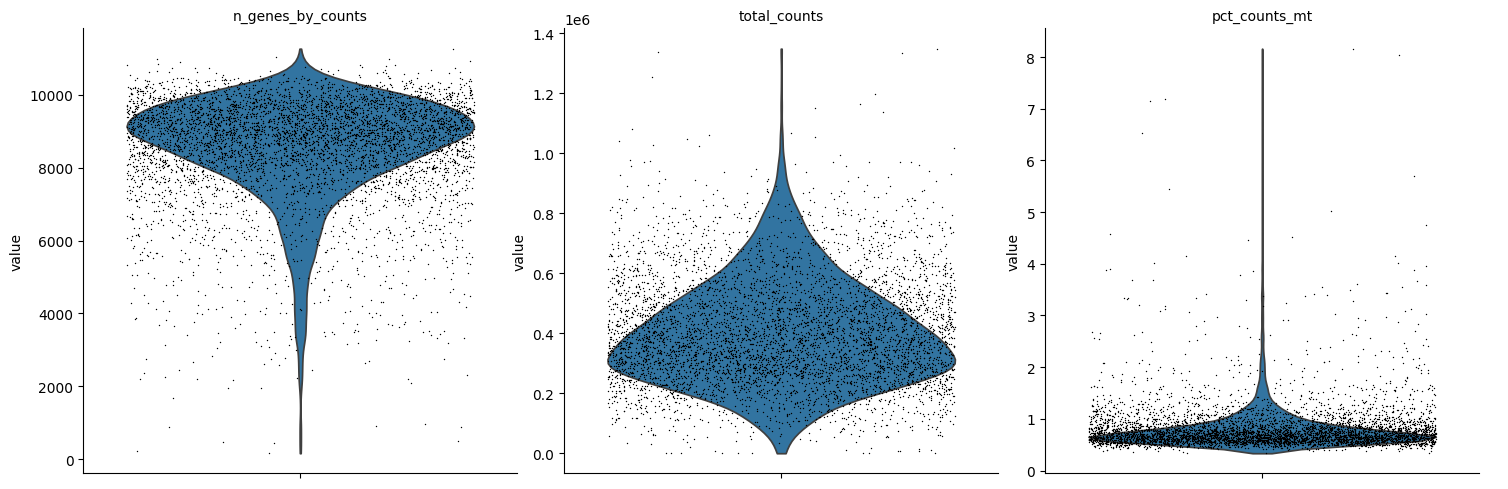

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

This kind of filtering is not necessary and can go through standard filtering. This filtering does a few  things
1. Find the median and standard deviation per cell type ('group') for each filtering metric
2. determine the variable cutoff as the median +/- 2*standard deviation
3. Filter Cells Based on these cutoffs

This works when there are differences in these qc metrics by group and hard filtering doesn't seem appropriate

In [19]:
import numpy as np
def variable_filter(adata):
    origins = np.unique(adata.obs['origin'])
    cells = []
    for origin in origins:
        df = adata[adata.obs['origin'] == origin]
        med = np.median(df.obs['pct_counts_mt'])
        sd = np.std(df.obs['pct_counts_mt'])
        cutoff = med + 2 * sd
        keep = df[df.obs['pct_counts_mt'] < cutoff].obs_names
        cells.append(keep)
    keep = np.concatenate(cells)
    subset_adata = adata[adata.obs_names.isin(keep)]
    return subset_adata

def nFeature_filter(adata):
    origins = np.unique(adata.obs['origin'])
    cells = []
    for origin in origins:
        df = adata[adata.obs['origin'] == origin]
        med = np.median(df.obs['n_genes_by_counts'])
        sd = np.std(df.obs['n_genes_by_counts'])
        cutoff = med - 2 * sd
        keep = df[df.obs['n_genes_by_counts'] > cutoff].obs_names
        cells.append(keep)
    keep = np.concatenate(cells)
    subset_adata = adata[adata.obs_names.isin(keep)]
    return subset_adata
adata = variable_filter(adata)
adata = nFeature_filter(adata)

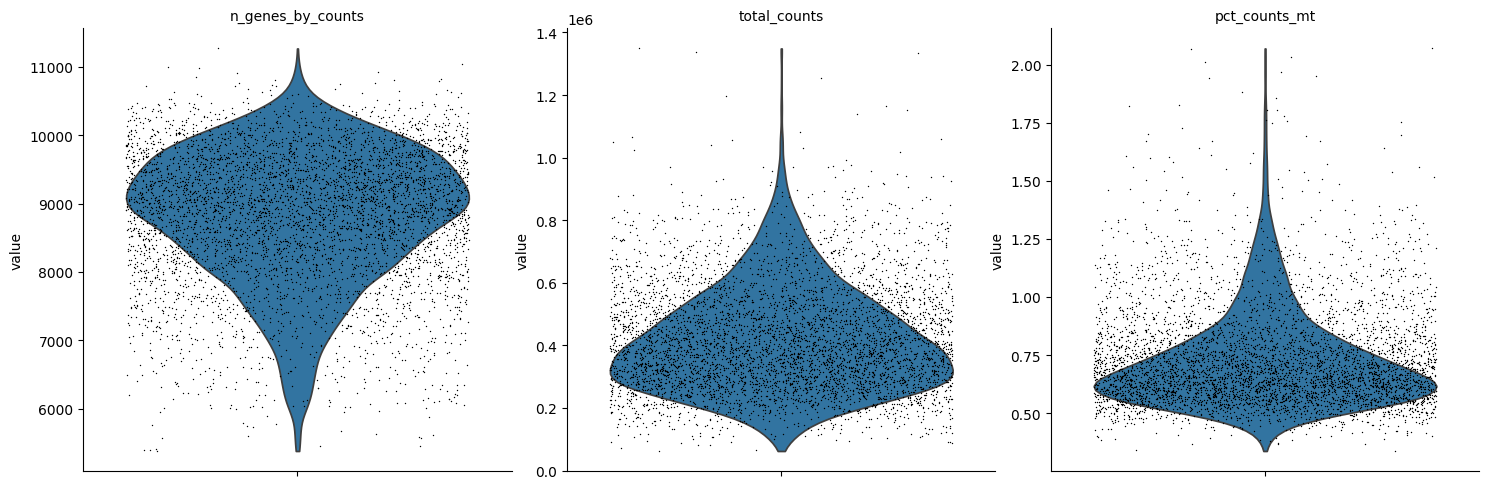

In [51]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

View the Object After filtering. Note these few things in the layers
1. matrix
2. ambiguous
3. spanning
4. spliced
5. unspliced

In [52]:
adata

View of AnnData object with n_obs × n_vars = 4995 × 40854
    obs: 'chip', 'cell_ID', 'origin', 'mouse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

# Split the AnnData object based on unique values in the obs column

# RUN SCVI
This data has batch effects and we want to correct the embedding based on batches. We have the "origin" metadata to view how well this works. Similar sites of origin should be grouped together in low dimensions

In [21]:
import scvi

Global seed set to 0


In [22]:
adata.raw = adata  
adata_raw = adata.copy() # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="matrix",
    batch_key="chip",
    subset=True,
)

In [23]:
# Initialize scVI object
import multiprocessing
import functools
scvi.model.SCVI.setup_anndata(adata,layer='matrix',batch_key = 'chip',labels_key='origin')
model = scvi.model.SCVI(adata,n_layers=2,n_latent=30,gene_likelihood='nb')
model.train()
# Update AnnData object with corrected data
adata.obsm["X_scVI"] = model.get_latent_representation()

SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_scVI'])

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount(

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [04:33<00:00,  1.46it/s, loss=2.88e+03, v_num=1]


In [24]:
adata

AnnData object with n_obs × n_vars = 4995 × 2000
    obs: 'cell_ID', 'chip', 'mouse', 'origin', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI', 'X_scVI_MDE'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

In [25]:
import umap
# Access the scvi latent space from AnnData object
latent = adata.obsm['X_scVI']

# Initialize UMAP object
umap_model = umap.UMAP()

# Fit UMAP model to the latent space
umap_result = umap_model.fit_transform(latent)

# Add UMAP coordinates to adata.obsm
adata.obsm['X_umap'] = umap_result

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

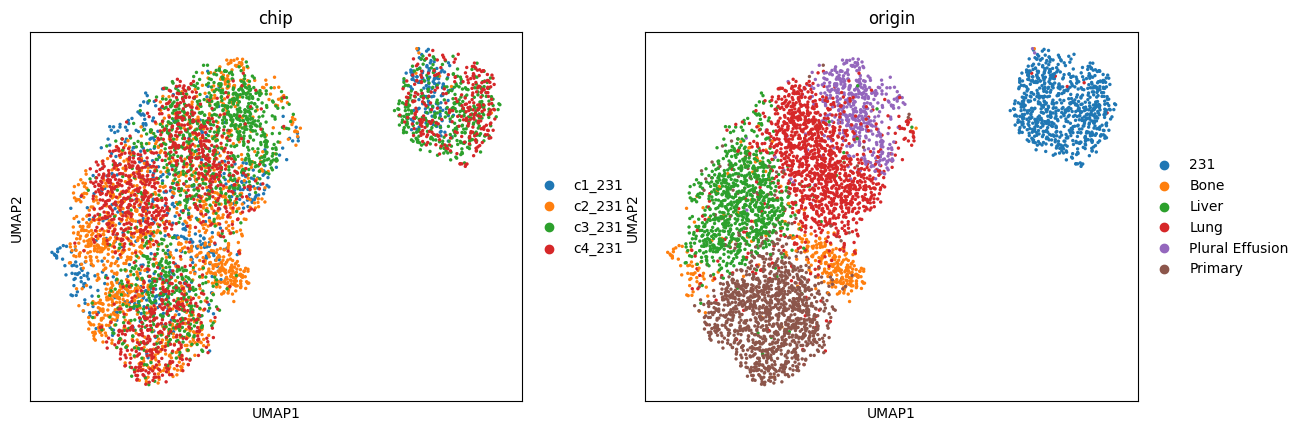

In [26]:
SCVI_LATENT_KEY = "X_scVI"
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color = ['chip','origin'])

In [51]:
adata_raw.obsm['X_scVI'] = model.get_latent_representation()
SCVI_MDE_KEY = "X_scVI_MDE"
sc.pp.neighbors(adata_raw, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_raw)
sc.tl.umap(adata_raw)
adata_raw.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_raw.obsm['X_scVI'])

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [55]:
#SAVE RAW FILE SO VELOCYTO CAN DO FEATURE SELECTION, NORMALIZATION,ETC
adata_raw.write_loom('adata_processed.loom')

The loom file will lack these fields:
{'X_umap', 'X_scVI', 'X_scVI_MDE'}
Use write_obsm_varm=True to export multi-dimensional annotations


## Run Velocyto

In [32]:
!conda install numpy scipy cython numba matplotlib scikit-learn h5py click -y
!pip install velocyto

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Channels:
 - defaults
 - conda-forge
 - soumith
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/bstrope/anaconda3/envs/scvi-env

  added / updated specs:
    - click
    - cython
    - h5py
    - matplotlib
    - numba
    - numpy
    - scikit-learn
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB
    _openmp_mutex-5.1          |            1_gnu          21 KB
    brotli-1.0.9               |       h5eee18b_8          18 KB
    brotli-bin-1.0.9           |       h5eee18b_8          19 KB
    bzip2-1.0.8                |       h5eee18b_6         262 KB
    ca-certificates-2024.7.2   |       h06a4308_0         127 KB
    certifi-2024.7.4           |   py39h06a4308_0         158 KB
    click-8.1.7                |   py39h06a4308_0         163 KB
    contourpy-1.2.0     

In [34]:
import velocyto as vcy

In [56]:
vlm = vcy.VelocytoLoom('adata_processed.loom')
#add in embedding information from scvi 
vlm.umap = adata_raw.obsm['X_umap']

A good first stem is to clean up the data a bit. Let’s remove the cells with extremely low unspliced detection

In [ ]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))

Let’s try now to select relevant features for the downstream analysis. Let’s make velocyto aware of the clusters annotation, if we have some

In [59]:
vlm.set_clusters(vlm.ca['origin'])

Now using the clustering annotation select the genes that are expressed above a threshold of total number of molecules in any of the clusters.

In [60]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

We can perform feature selection.

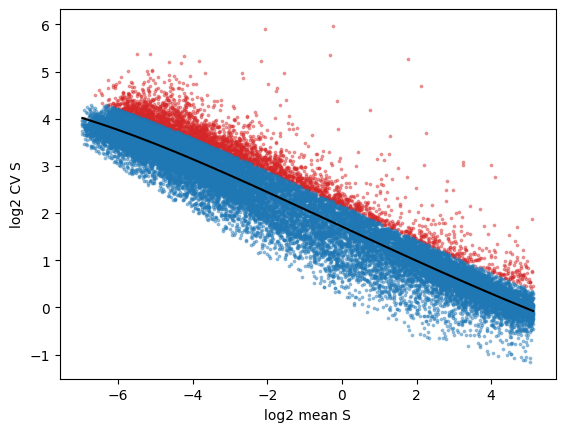

In [61]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

Finally we can normalize our data by size (total molecule count)

In [62]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

### Preparation for Gamma Fit
For the preparation of the gamma fit we smooth the data using a kNN neighbors pooling approach. kNN neighbors can be calculated directly in gene expression space or reduced PCA space, using either correlation distance or euclidean distance. One example of set of parameters is provided below.

In [63]:
vlm.perform_PCA()
vlm.knn_imputation(n_pca_dims=20, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=16)

To fit gamma to every gene that survived the filtering step run

In [64]:
vlm.fit_gammas()

The calculate velocity and extrapolate the future state of the cells:

In [65]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

### Projecion of Velocity onto embeddings

In [78]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="umap", transform="sqrt", psc=1,
                             n_neighbors=3500, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [80]:
import matplotlib.pyplot as plt

In [87]:
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

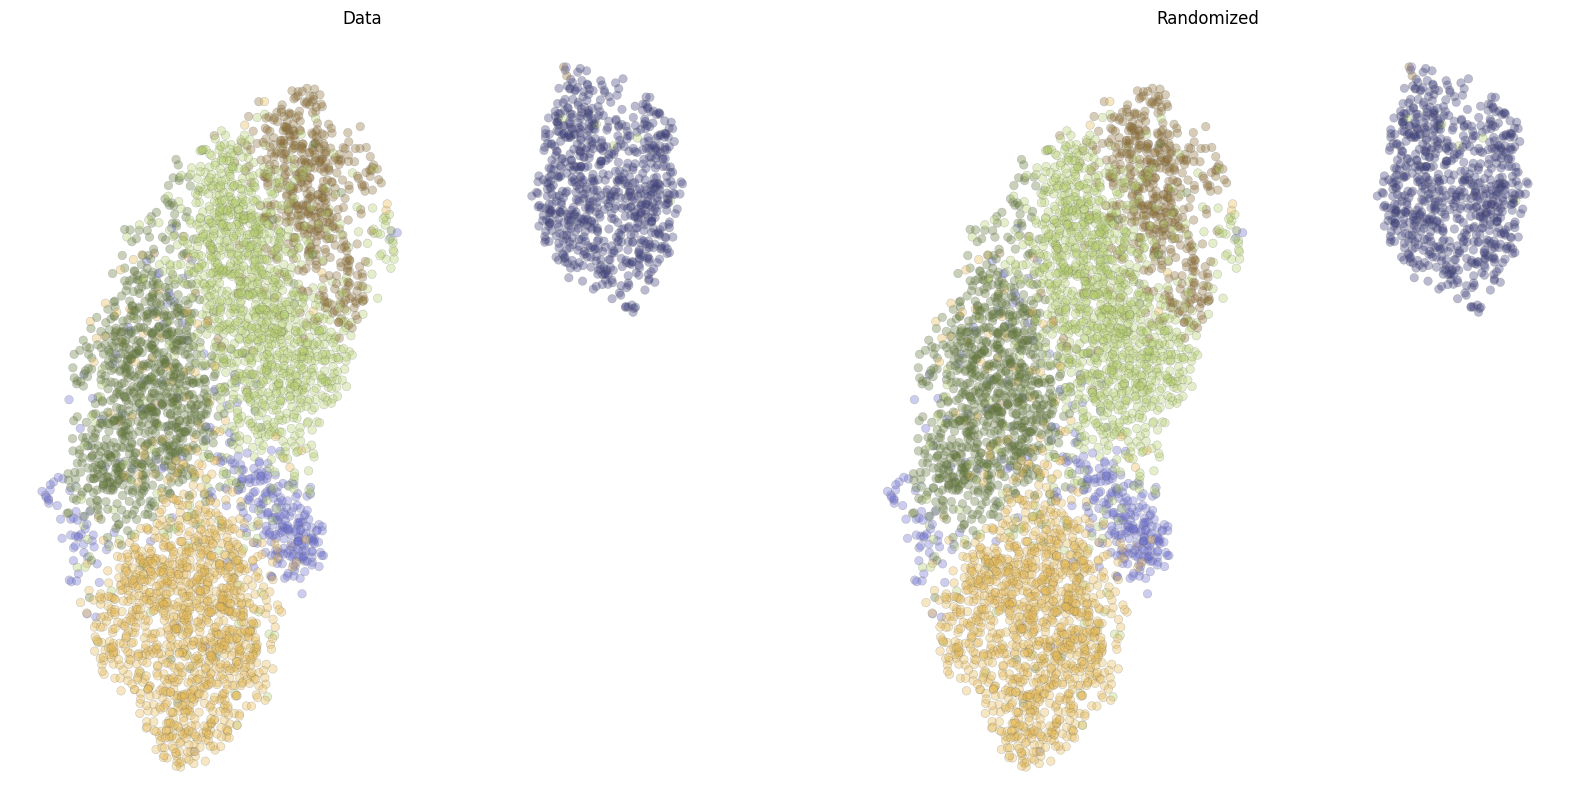

In [86]:
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.6,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=4.5,
                    plot_random=True, scale_type="absolute")